In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models

from build_model_ed import build_model_1, build_model_2, build_model_3
from build_model_lstm import build_model_lstm_1, build_model_lstm_2
from get_frames import get_frames
from get_encoder_decoder import get_encoder_decoder
from get_errors import get_ssim, get_mse, get_errors
from assemble_image import assemble_image

In [4]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#load data
test_size = 0.1
stride_step = 50
norm_factor=1
dtype = 'uint8'

#filename = f'save_data/e_d_train_all_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
filename = f'save_data/e_d_test_all_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
#load data
with open(filename, 'rb') as f:
    image_list,frames_data = pickle.load(f)
    
#get input shape for encoder-decoder model
input_shape_e_d = frames_data.shape[1:]
del frames_data 

print(f'Image files: {image_list}')
print(f'Encoder-decoder input shape: {input_shape_e_d}')

Image files: ['Fold21.png', 'Pucker3.png', 'Fold3.png', 'Pucker23.png', 'Pucker16.png', 'Twist31.png', 'Pucker7.png', 'Pucker26.png', 'Pucker24.png']
Encoder-decoder input shape: (2048, 50, 3)


In [6]:
unit_numb = 5
#lstm settings
cells_list = [10]
ifSummary = True
ifEncoder=True
ifDecoder=True

ifDense = False
input_shape = (None, unit_numb)
cells_list_str = '_'.join(str(x) for x in cells_list)
model_ed_name = f'model_ed_2_ps_2_bn_True_du_{unit_numb}'
model_lstm_name = f'model_lstm_units_{unit_numb}_bs2_{input_shape[-1]}_{cells_list_str}_ifDense_{ifDense}'

print(f'\nModel encoder-decoder name: {model_ed_name}')
print(f'\nModel lstm name: {model_lstm_name}')


Model encoder-decoder name: model_ed_2_ps_2_bn_True_du_5

Model lstm name: model_lstm_units_5_bs2_5_10_ifDense_False


In [7]:
#load models
print(f'\nModel name: {model_ed_name}\n\n')

loss = 'mean_squared_error'
optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=0.1, name="Adadelta")

#input_shape = frames_data.shape[1:]
input_shape = input_shape_e_d

filename = f'saved_models/{model_ed_name}_settings.pkl'
#load nn settings
with open(filename, 'rb') as f:
    dense_units,ifBatchNorm,kernel_size,nn_blocks = pickle.load(f)
model_settings = (input_shape, dense_units,ifBatchNorm,kernel_size,nn_blocks)
model_weights_path = f'saved_models/{model_ed_name}/{model_ed_name}'

model_ed_list = get_encoder_decoder(
    model_ed_name, 
    model_weights_path, 
    model_settings, 
    loss, optimizer, 
    ifEncoder=ifEncoder, 
    ifDecoder=ifDecoder, 
    ifSummary=ifSummary
)


Model name: model_ed_2_ps_2_bn_True_du_5



#####Main model model#####

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048, 50, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 2048, 50, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 2048, 50, 4)       112       
                                                                 
 batch_normalization (Batch  (None, 2048, 50, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 1024, 50, 4)       0         
 D)                                                              
                                                      

                                                                 
 up_sampling2d_5 (UpSamplin  (None, 512, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 512, 50, 8)        1160      
                                                                 
 batch_normalization_14 (Ba  (None, 512, 50, 8)        32        
 tchNormalization)                                               
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 1024, 50, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 1024, 50, 4)       292       
                                                                 
 batch_normalization_15 (Ba  (None, 1024, 50, 4)       16        
 tchNormal

                                                                 
 up_sampling2d_1 (UpSamplin  (None, 32, 50, 120)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 50, 100)       108100    
                                                                 
 batch_normalization_10 (Ba  (None, 32, 50, 100)       400       
 tchNormalization)                                               
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 64, 50, 100)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 50, 64)        57664     
                                                                 
 batch_normalization_11 (Ba  (None, 64, 50, 64)        256       
 tchNormal

In [8]:
#load lstm model

print(f'\nModel name: {model_lstm_name}')

# extract network parameters from model name
pars = model_lstm_name.split('_')
input_shape = (None, int(pars[3]))
ifDense = eval(pars[-1])
cells_list = [int(x) for x in pars[6:-2]]

loss = 'mean_squared_error'
optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=0.1, name="Adadelta")
model_lstm = build_model_lstm_1(input_shape, cells_list, ifDense=ifDense, ifDropout=False)
model_lstm.compile(loss=loss, 
              optimizer=optimizer, )

if ifSummary:
    model_lstm.summary() 


model_lstm.load_weights(f'saved_models/lstm/{model_lstm_name}/{model_lstm_name}').expect_partial()  


Model name: model_lstm_units_5_bs2_5_10_ifDense_False
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 5)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 10)          640       
                                                                 
 conv1d (Conv1D)             (None, None, 5)           155       
                                                                 
Total params: 795 (3.11 KB)
Trainable params: 795 (3.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#TODO
#encoding-decoding into a function

In [9]:
image_list

['Fold21.png',
 'Pucker3.png',
 'Fold3.png',
 'Pucker23.png',
 'Pucker16.png',
 'Twist31.png',
 'Pucker7.png',
 'Pucker26.png',
 'Pucker24.png']

In [13]:
#choose image
test_case = image_list[0]
stride_step = 50
frames_to_predict=1

#get frames from the image
path_list = ['PuckerImages//RGB_cropped',
             'TwistImages//RGB',
             'FoldImages//RGB',]

print(f'Chosen image: {test_case}')
for path in path_list:
    if test_case[:4]==path[:4]:
        break
        
img = Image.open(f'{path}//{test_case}')
image_data_gt = np.array(img, dtype=dtype)
#crop the end
image_data_gt = image_data_gt[:,:-96,:]
print(f'Image shape: {image_data_gt.shape}')
#get frames
image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
print(f'Framed image shape: {image_data_frames_gt.shape}')

Chosen image: Fold21.png
Image shape: (2048, 4000, 3)
Framed image shape: (80, 2048, 50, 3)

Model name: model_ed_2_ps_2_bn_True_du_5
##########Encoding started#############
3/3 [==============================] - 3s 556ms/step
##########Encoding finished#############
Time for prediction (whole image): 3.66 sec
Encoded shape: (80, 5)


##########Decoding started#############
3/3 [==============================] - 3s 503ms/step
##########Decoding finished#############
Time for prediction (whole image): 2.83 sec
Decoded shape: (80, 2048, 50, 3)

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.09 sec
3/3 [==============================] - 0s 12ms/step

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape

Text(0.5, 1.0, 'Total SSIM: 0.89,   Total MSE_gray: 702.59,   Total MSE_RGB: 1287.05')

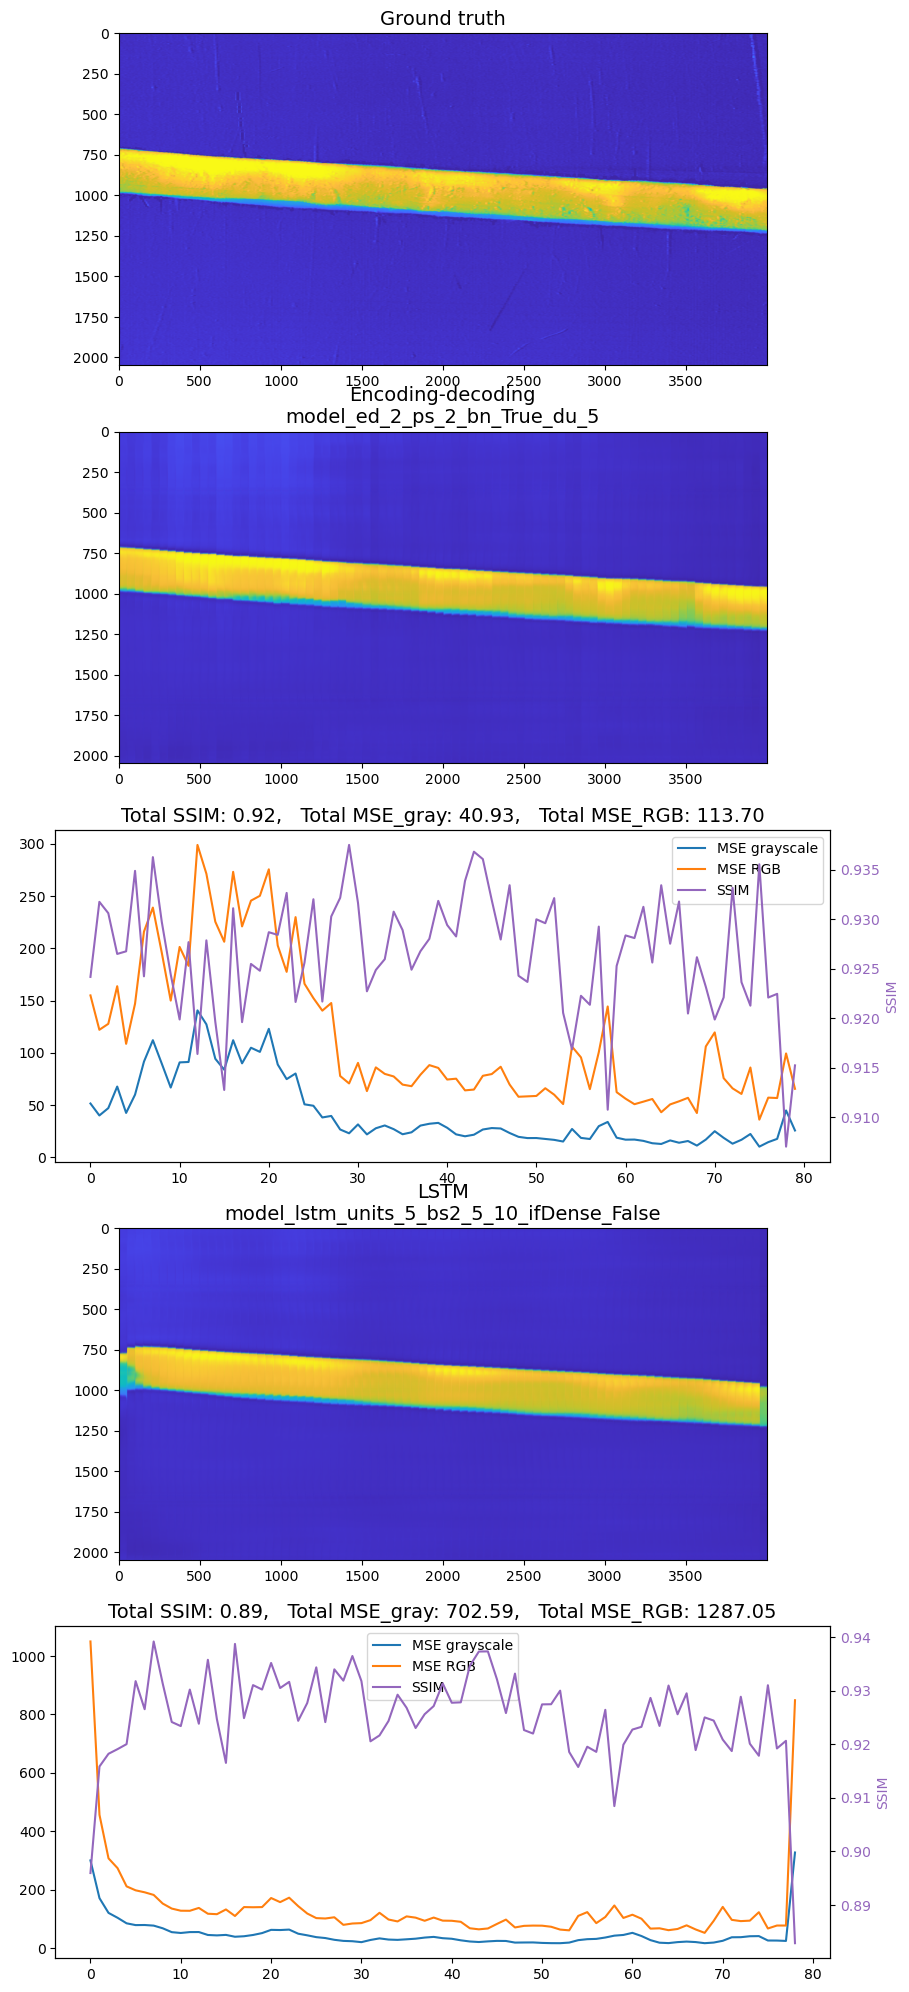

In [11]:
numb_row = 5
fig, axes = plt.subplots(numb_row,1, figsize=(10,5*numb_row))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14


ax = axes[0]
ax.imshow(image_data_gt)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

print(f'\nModel name: {model_ed_name}')
model_encoder = model_ed_list[0]
model_decoder = model_ed_list[1]

#get encoded data
print('##########Encoding started#############')
tic = time.perf_counter()
image_data_frames_encoded = model_encoder.predict(image_data_frames_gt)     
toc = time.perf_counter()
print('##########Encoding finished#############')
print(f'Time for prediction (whole image): {toc - tic:.2f} sec')
print(f'Encoded shape: {image_data_frames_encoded.shape}\n\n')

#get decoded data
print('##########Decoding started#############')
tic = time.perf_counter()
if ifED_forloop:
    #predict frame by frame in a for loop
    #potentially usefull for further lstm use
    for i, frame_data_encoded in enumerate(image_data_frames_encoded):    
        frame_data_decoded = model_decoder.predict(np.expand_dims(frame_data_encoded, axis=0),verbose = 0)

        if i==0:
            image_data_frames_decoded = frame_data_decoded
        else:
            image_data_frames_decoded = np.append(image_data_frames_decoded, frame_data_decoded, axis=0)
else:
    image_data_frames_decoded = model_decoder.predict(image_data_frames_encoded)   
toc = time.perf_counter()
print('##########Decoding finished#############')
print(f'Time for prediction (whole image): {toc - tic:.2f} sec')
print(f'Decoded shape: {image_data_frames_decoded.shape}')


#reshape from separate frames into a single image
print('\nReshaping separate frames into a single image')
tic = time.perf_counter()
original_shape = image_data_frames_decoded.shape
#swap axis
image_data_rsh1 = np.swapaxes(image_data_frames_decoded,1,2)
print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
#reshape
image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
#swap axis back
image_data_predicted = np.swapaxes(image_data_rsh2,0,1)
print(f'Image shape after final reshape: {image_data_predicted.shape}')
#convert float to in
image_data_predicted=image_data_predicted.astype(int)
toc = time.perf_counter()
print(f'Time for image assembly: {toc - tic:.2f} sec')

ax = axes[1]
ax.imshow(image_data_predicted)
ax.set_title(f'Encoding-decoding\n{model_ed_name}', fontsize=fontsize_sec)

#get errors
ax = axes[2]

ssim_frames, mse_gray_frames, mse_rgb_frames = get_errors(
    image_data_frames_gt, 
    image_data_frames_decoded
)

ssim_image, mse_gray_image, mse_rgb_image = get_errors(
    image_data_gt, 
    image_data_predicted
)
ax.plot(mse_gray_frames, label='MSE grayscale')
ax.plot(mse_rgb_frames, label='MSE RGB')

color = 'tab:purple'
ax_add = ax.twinx()
ax_add.plot(ssim_frames, color=color, label='SSIM')
ax_add.set_ylabel('SSIM', color=color)
ax_add.tick_params(axis='y', labelcolor=color)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_add.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)
ax.set_title(
    f'Total SSIM: {ssim_image:.2f},   Total MSE_gray: {mse_gray_image:.2f},   Total MSE_RGB: {mse_rgb_image:.2f}',
    fontsize=fontsize_sec
)



#lstm_prediction
image_data_frames_lstm_encoded = model_lstm.predict(np.array([image_data_frames_encoded]))
#decode
image_data_frames_lstm_decoded = model_decoder.predict(image_data_frames_lstm_encoded[0])
#reshape from separate frames into a single image
print('\nReshaping separate frames into a single image')
tic = time.perf_counter()
original_shape = image_data_frames_lstm_decoded.shape
#swap axis
image_data_rsh1 = np.swapaxes(image_data_frames_lstm_decoded,1,2)
print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
#reshape
image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
#swap axis back
image_data_lstm_predicted = np.swapaxes(image_data_rsh2,0,1)
print(f'Image shape after final reshape: {image_data_lstm_predicted.shape}')
#convert float to int
image_data_lstm_predicted=image_data_lstm_predicted.astype(int)
toc = time.perf_counter()
print(f'Time for image assembly: {toc - tic:.2f} sec')

ax = axes[3]
ax.imshow(image_data_lstm_predicted)
ax.set_title(f'LSTM\n{model_lstm_name}', fontsize=fontsize_sec)

#get errors
ax = axes[4]

image_gt_1 = image_data_gt[:-stride_step]
image_pred_2 = image_data_lstm_predicted[stride_step:]
image_gt_1_frames = image_data_frames_gt[:-1]
image_pred_2_frames = image_data_frames_lstm_decoded[1:]

ssim_frames, mse_gray_frames, mse_rgb_frames = get_errors(
    image_gt_1_frames, 
    image_pred_2_frames
)

ssim_image, mse_gray_image, mse_rgb_image = get_errors(
    image_gt_1, 
    image_pred_2
)
ax.plot(mse_gray_frames, label='MSE grayscale')
ax.plot(mse_rgb_frames, label='MSE RGB')

color = 'tab:purple'
ax_add = ax.twinx()
ax_add.plot(ssim_frames, color=color, label='SSIM')
ax_add.set_ylabel('SSIM', color=color)
ax_add.tick_params(axis='y', labelcolor=color)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_add.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)
ax.set_title(
    f'Total SSIM: {ssim_image:.2f},   Total MSE_gray: {mse_gray_image:.2f},   Total MSE_RGB: {mse_rgb_image:.2f}',
    fontsize=fontsize_sec
)

In [16]:
frames_to_predict=1

##########Encoding started#############
3/3 [==============================] - 0s 15ms/step
##########Encoding finished#############
Encoded shape: (80, 5)


##########Decoding started#############
3/3 [==============================] - 0s 13ms/step
##########Decoding finished#############
Decoded shape: (80, 2048, 50, 3)

Reshaping separate frames into a single image


##########LSTM prediction finished#############

Timesteps prediction: 1
Initial input shape: (1, 5)

Predicting several timesteps, current step being predicted: 1
Input shape: (1, 5)
1/1 [==============================] - 0s 13ms/step
Output shape: (1, 5)
Resulting shape: (2, 5)

Timesteps prediction: 2
Initial input shape: (2, 5)

Predicting several timesteps, current step being predicted: 2
Input shape: (2, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (3, 5)

Timesteps prediction: 3
Initial input shape: (3, 5)

Predicting several timesteps, current step being predicted:

1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (35, 5)

Timesteps prediction: 35
Initial input shape: (35, 5)

Predicting several timesteps, current step being predicted: 35
Input shape: (35, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (36, 5)

Timesteps prediction: 36
Initial input shape: (36, 5)

Predicting several timesteps, current step being predicted: 36
Input shape: (36, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (37, 5)

Timesteps prediction: 37
Initial input shape: (37, 5)

Predicting several timesteps, current step being predicted: 37
Input shape: (37, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (38, 5)

Timesteps prediction: 38
Initial input shape: (38, 5)

Predicting several timesteps, current step being predicted: 38
Input shape: (38, 5)
1/1 [==============================] - 0s 12ms/s

1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (70, 5)

Timesteps prediction: 70
Initial input shape: (70, 5)

Predicting several timesteps, current step being predicted: 70
Input shape: (70, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (71, 5)

Timesteps prediction: 71
Initial input shape: (71, 5)

Predicting several timesteps, current step being predicted: 71
Input shape: (71, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (72, 5)

Timesteps prediction: 72
Initial input shape: (72, 5)

Predicting several timesteps, current step being predicted: 72
Input shape: (72, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (1, 5)
Resulting shape: (73, 5)

Timesteps prediction: 73
Initial input shape: (73, 5)

Predicting several timesteps, current step being predicted: 73
Input shape: (73, 5)
1/1 [==============================] - 0s 12ms/s

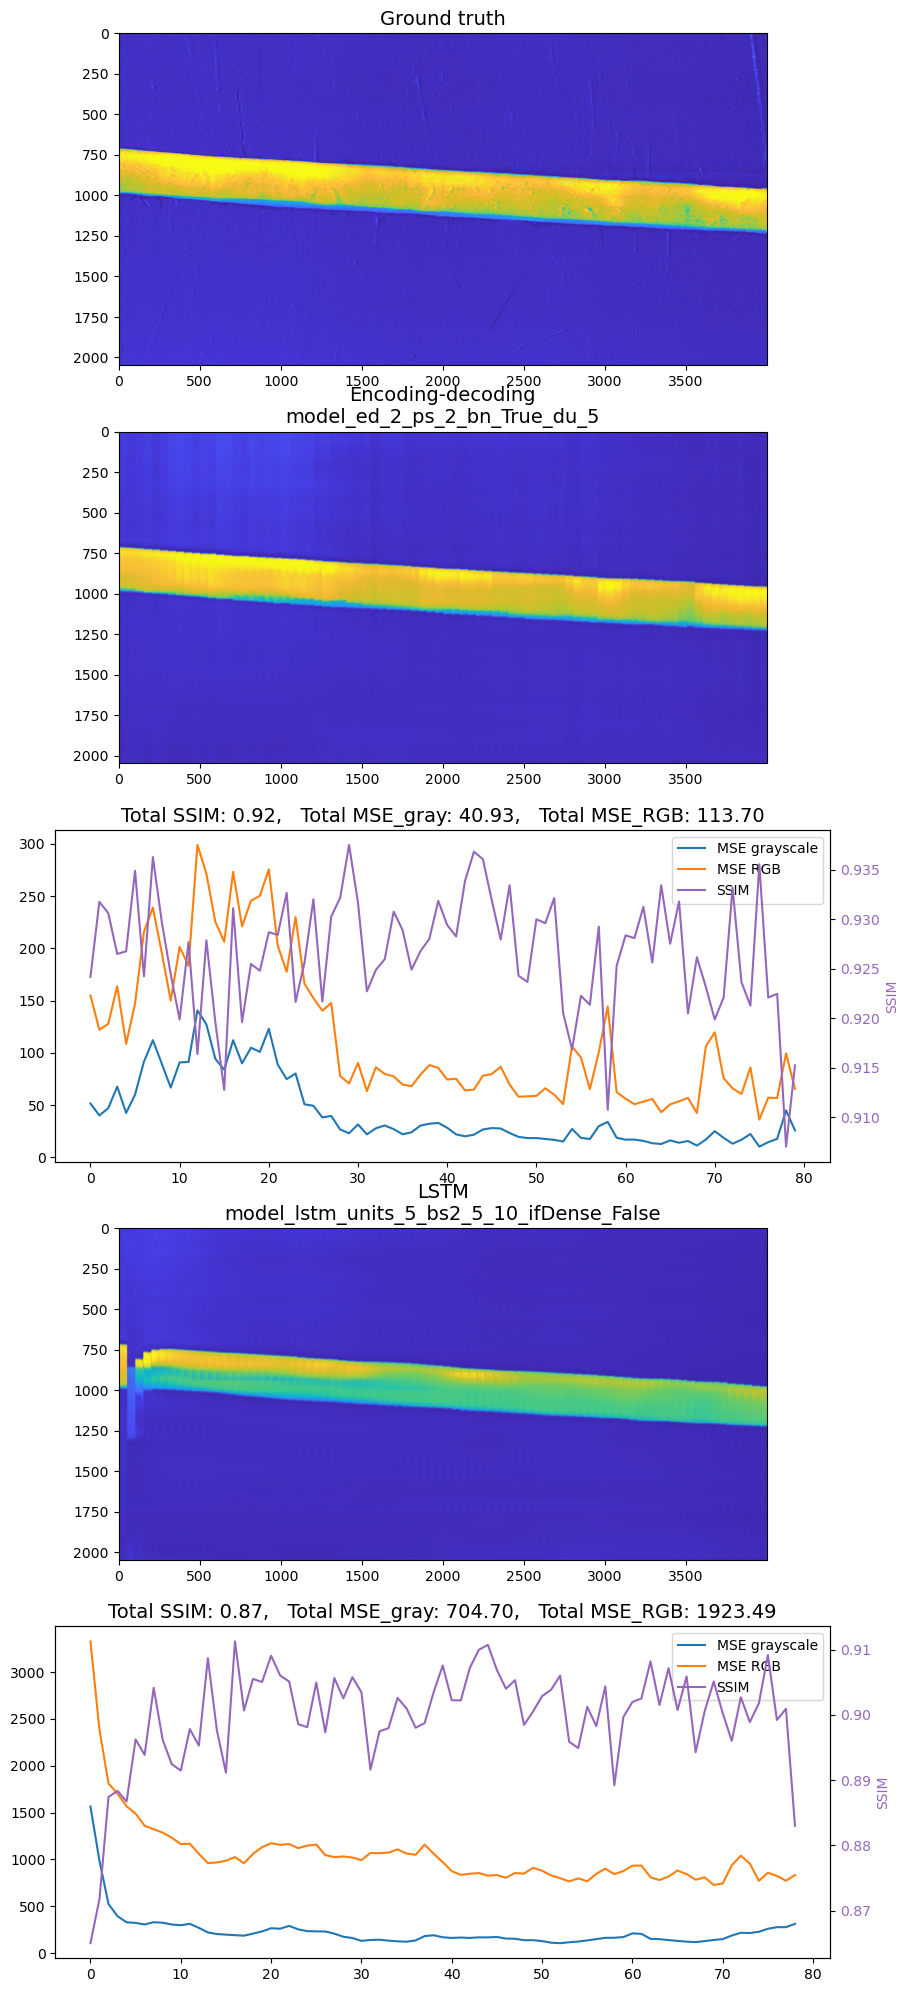

In [17]:
#numb_col = len(model_dict.keys())+1
numb_row = 5
fig, axes = plt.subplots(numb_row,1, figsize=(10,5*numb_row))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14
#fig.suptitle(f'{model_name}', fontsize=fontsize_sec+2, fontweight='bold', y=0.93)

ax = axes[0]
ax.imshow(image_data_gt)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

model_encoder = model_ed_list[0]
model_decoder = model_ed_list[1]

#get encoded data
print('##########Encoding started#############')
image_data_frames_encoded = model_encoder.predict(image_data_frames_gt)     
print('##########Encoding finished#############')
print(f'Encoded shape: {image_data_frames_encoded.shape}\n\n')

#get decoded data
print('##########Decoding started#############')
image_data_frames_decoded = model_decoder.predict(image_data_frames_encoded)   
print('##########Decoding finished#############')
print(f'Decoded shape: {image_data_frames_decoded.shape}')

#reshape from separate frames into a single image
image_data_predicted = assemble_image(image_data_frames_decoded)

ax = axes[1]
ax.imshow(image_data_predicted)
ax.set_title(f'Encoding-decoding\n{model_ed_name}', fontsize=fontsize_sec)

#get errors
ax = axes[2]

ssim_frames, mse_gray_frames, mse_rgb_frames = get_errors(
    image_data_frames_gt, 
    image_data_frames_decoded
)

ssim_image, mse_gray_image, mse_rgb_image = get_errors(
    image_data_gt, 
    image_data_predicted
)
ax.plot(mse_gray_frames, label='MSE grayscale')
ax.plot(mse_rgb_frames, label='MSE RGB')

color = 'tab:purple'
ax_add = ax.twinx()
ax_add.plot(ssim_frames, color=color, label='SSIM')
ax_add.set_ylabel('SSIM', color=color)
ax_add.tick_params(axis='y', labelcolor=color)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_add.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)
ax.set_title(
    f'Total SSIM: {ssim_image:.2f},   Total MSE_gray: {mse_gray_image:.2f},   Total MSE_RGB: {mse_rgb_image:.2f}',
    fontsize=fontsize_sec
)


#lstm_prediction
#image_data_frames_lstm_encoded = model_lstm.predict(np.array([image_data_frames_encoded]))
print('\n\n##########LSTM prediction finished#############')
frames_to_pred_total = image_data_frames_encoded.shape[0]-frames_to_predict
#predict with lstm step by step
#get ground truth data for further input to the model
image_data_frames_lstm_encoded = image_data_frames_encoded[:frames_to_predict]
for j in range(frames_to_pred_total):
    #reset lstm before using it within the step
    model_lstm.reset_states()
    print(f'\nTimesteps prediction: {j+1}\nInitial input shape: {image_data_frames_lstm_encoded.shape}')
    track_input = image_data_frames_encoded[:j+1]
    for jj in range(frames_to_predict):
        #predict
        print(f'\nPredicting several timesteps, current step being predicted: {j+jj+1}')
        print(f'Input shape: {track_input.shape}')
        predicted_sequence = model_lstm.predict(track_input[np.newaxis])
        last_timestep = predicted_sequence[::, -1]
        track_input = last_timestep
        #track_input = np.concatenate((track_input, last_timestep), axis=0)
        print(f'Output shape: {track_input.shape}')

    #last_timestep = track_input[-1][np.newaxis]
    image_data_frames_lstm_encoded = np.concatenate((image_data_frames_lstm_encoded, last_timestep), axis=0)
    print(f'Resulting shape: {image_data_frames_lstm_encoded.shape}')
    

            
#decode
image_data_frames_lstm_decoded = model_decoder.predict(image_data_frames_lstm_encoded)
#reshape from separate frames into a single image
print('\nReshaping separate frames into a single image')
tic = time.perf_counter()
original_shape = image_data_frames_lstm_decoded.shape
#swap axis
image_data_rsh1 = np.swapaxes(image_data_frames_lstm_decoded,1,2)
print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
#reshape
image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
#swap axis back
image_data_lstm_predicted = np.swapaxes(image_data_rsh2,0,1)
print(f'Image shape after final reshape: {image_data_lstm_predicted.shape}')
#convert float to int
image_data_lstm_predicted=image_data_lstm_predicted.astype(int)
toc = time.perf_counter()
print(f'Time for image assembly: {toc - tic:.2f} sec')

if 1:
    ax = axes[3]
    ax.imshow(image_data_lstm_predicted)
    ax.set_title(f'LSTM\n{model_lstm_name}', fontsize=fontsize_sec)

    #get errors
    ax = axes[4]

    image_gt_1 = image_data_gt[:-stride_step]
    image_pred_2 = image_data_lstm_predicted[stride_step:]
    image_gt_1_frames = image_data_frames_gt[:-1]
    image_pred_2_frames = image_data_frames_lstm_decoded[1:]

    ssim_frames, mse_gray_frames, mse_rgb_frames = get_errors(
        image_gt_1_frames, 
        image_pred_2_frames
    )

    ssim_image, mse_gray_image, mse_rgb_image = get_errors(
        image_gt_1, 
        image_pred_2
    )
    ax.plot(mse_gray_frames, label='MSE grayscale')
    ax.plot(mse_rgb_frames, label='MSE RGB')

    color = 'tab:purple'
    ax_add = ax.twinx()
    ax_add.plot(ssim_frames, color=color, label='SSIM')
    ax_add.set_ylabel('SSIM', color=color)
    ax_add.tick_params(axis='y', labelcolor=color)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_add.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2)
    ax.set_title(
        f'Total SSIM: {ssim_image:.2f},   Total MSE_gray: {mse_gray_image:.2f},   Total MSE_RGB: {mse_rgb_image:.2f}',
        fontsize=fontsize_sec
    )

In [19]:
frames_to_predict=6




Step 1
Input shape: (1, 2048, 50, 3)

##########Encoding started#############
1/1 [==============================] - 0s 12ms/step
##########Encoding finished############
Encoded shape: (1, 5)

##########LSTM prediction started#############
Predicting several timesteps, current step being predicted: 1
Input shape: (1, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (2, 5)
Predicting several timesteps, current step being predicted: 2
Input shape: (1, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (3, 5)
Predicting several timesteps, current step being predicted: 3
Input shape: (1, 5)
1/1 [==============================] - 0s 11ms/step
Output shape: (4, 5)
Predicting several timesteps, current step being predicted: 4
Input shape: (1, 5)
1/1 [==============================] - 0s 12ms/step
Output shape: (5, 5)
Predicting several timesteps, current step being predicted: 5
Input shape: (1, 5)
1/1 [==============================] - 0s 12ms/step
Out

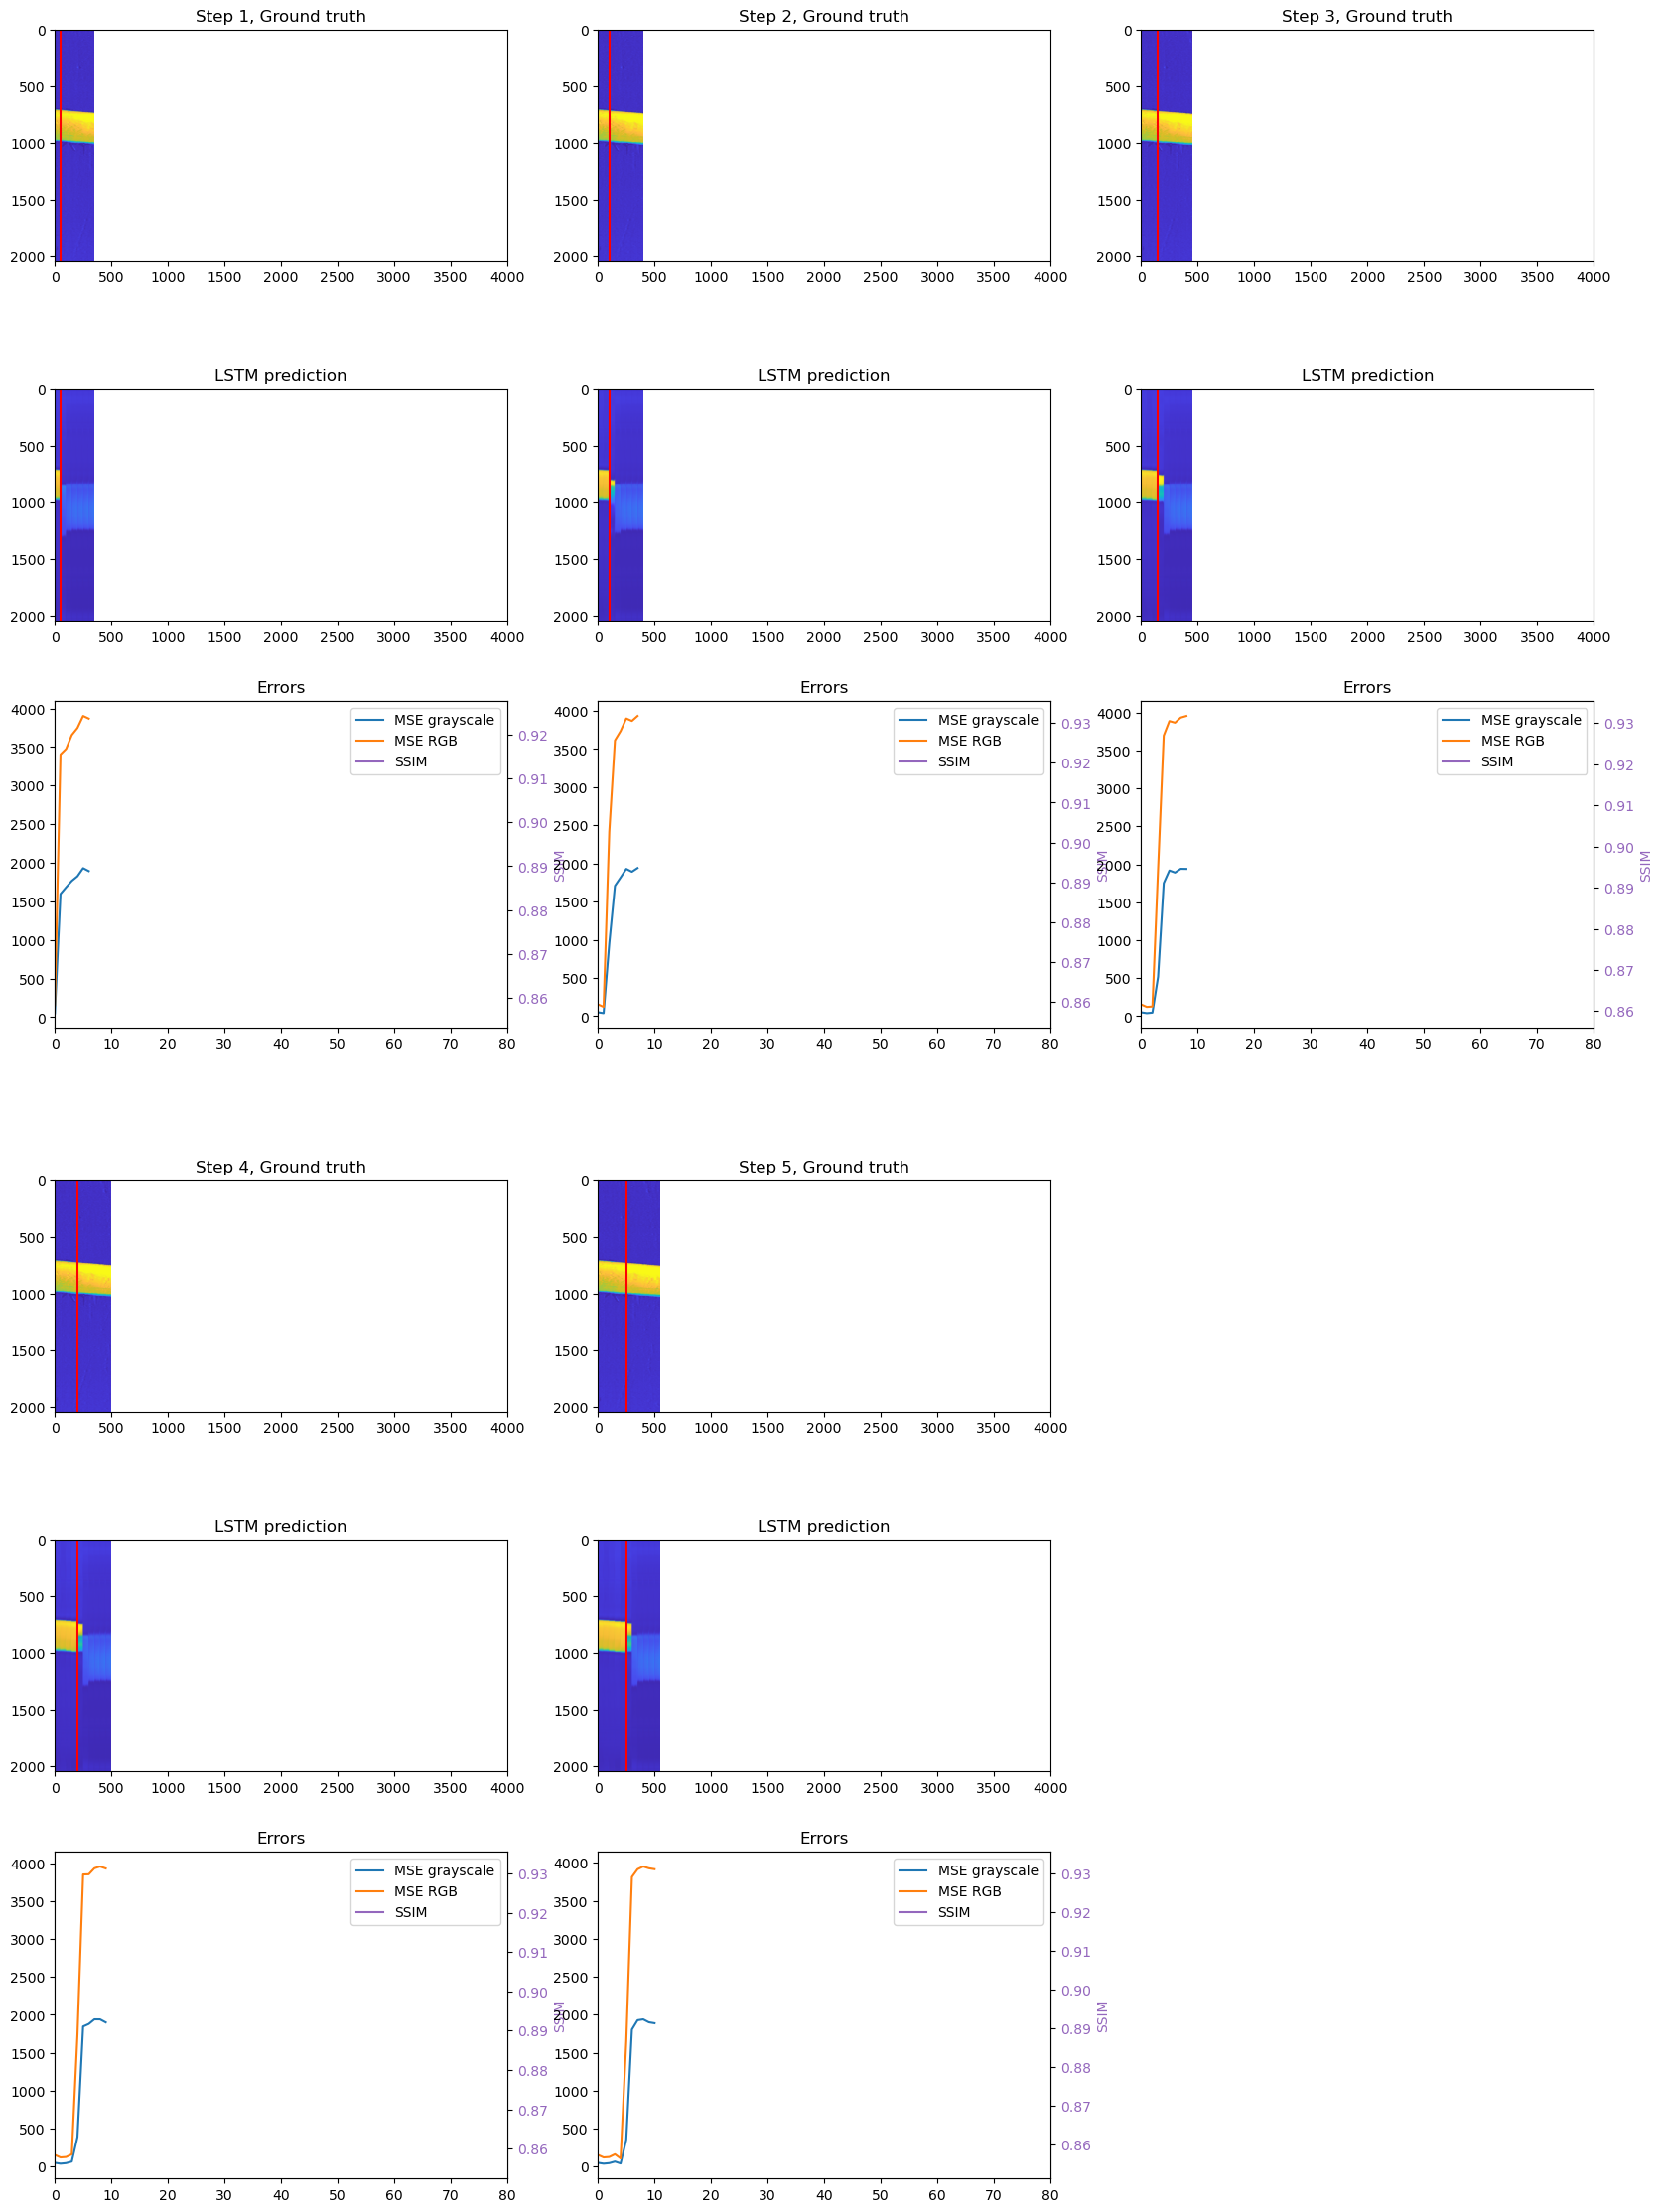

In [20]:

numb_cols = 3
numb_plots_per_frame = 3

number_of_frames = image_data_frames_gt.shape[0]
numb_rows = int(np.ceil(number_of_frames/numb_cols))

model_encoder = model_ed_list[0]
model_decoder = model_ed_list[1]


fig = plt.figure(figsize=(20, 15*numb_rows))
outer = gridspec.GridSpec(numb_rows, numb_cols, wspace=0.2, hspace=0.1)
linewidth = 3.0
fontsize_sec = 14
'''
the prediction is implemented through for loop as it is how the data is obtained in the real AFP process
input data is received in chuncks as tape moves
'''
frames_to_pred_total = number_of_frames-frames_to_predict
frames_to_pred_total=5
for i in range(frames_to_pred_total):
    #reset lstm state to get independent prediction between timesteps (batches)
    model_lstm.reset_states()
    print(f'\n\n\nStep {i+1}')
    image_data_frames_input = image_data_frames_gt[:i+1]
    print(f'Input shape: {image_data_frames_input.shape}')
    print('\n##########Encoding started#############')
    image_data_frames_encoded = model_encoder.predict(image_data_frames_input)
    print('##########Encoding finished############')
    print(f'Encoded shape: {image_data_frames_encoded.shape}')
    
    print('\n##########LSTM prediction started#############')
    image_data_frames_lstm = np.copy(image_data_frames_encoded)
    lstm_input = image_data_frames_lstm
    for ii in range(frames_to_predict):
        #predict
        print(f'Predicting several timesteps, current step being predicted: {i+ii+1}')
        print(f'Input shape: {lstm_input.shape}')
        #append the last predicted frame to the original input
        predicted_sequence = model_lstm.predict(lstm_input[np.newaxis])
        last_timestep = predicted_sequence[::, -1]
        lstm_input = last_timestep
        image_data_frames_lstm = np.concatenate((image_data_frames_lstm, last_timestep), axis=0)
        print(f'Output shape: {image_data_frames_lstm.shape}')
    print('##########LSTM prediction finished#############')
    
    print('\n##########Decoding started#############')
    image_data_frames_decoded = model_decoder.predict(image_data_frames_lstm)
    print('##########Decoding finished############')
    print(f'Decoded shape: {image_data_frames_decoded.shape}')
    
    #assemble the whole image from frames
    image_data_predicted = assemble_image(image_data_frames_decoded)
    
    #get errors
    index_predicted = image_data_frames_decoded.shape[0]
    image_gt_1_frames = image_data_frames_gt[:index_predicted]
    image_pred_2_frames = image_data_frames_decoded

    ssim_frames, mse_gray_frames, mse_rgb_frames = get_errors(
        image_gt_1_frames, 
        image_pred_2_frames
            )
    
    
    
    #plot
    inner = gridspec.GridSpecFromSubplotSpec(
        numb_plots_per_frame, 1,
        subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    #plot ground truth
    ax = plt.Subplot(fig, inner[0])
    x_lim = image_data_gt.shape[1]
    #plot only a portion of gt for comparison
    index_current = image_data_predicted.shape[1]
    ax.imshow(image_data_gt[:,:index_current,:])
    ax.set_xlim(0, x_lim)
    ax.set_title(f'Step {i+1}, Ground truth')
    #plot separator input/prediction
    x_separator = image_data_frames_input.shape[0]*image_data_frames_input.shape[2]
    ax.axvline(x = x_separator, color = 'red')
    fig.add_subplot(ax)
    
    #plot prediction
    ax = plt.Subplot(fig, inner[1])
    ax.imshow(image_data_predicted)
    ax.set_title(f'LSTM prediction')
    ax.set_xlim(0, x_lim)
    x_separator = image_data_frames_input.shape[0]*image_data_frames_input.shape[2]
    ax.axvline(x = x_separator, color = 'red')
    fig.add_subplot(ax)
    
    #plot errors
    ax = plt.Subplot(fig, inner[2])
    ax.set_title(f'Errors')   
    ax.plot(mse_gray_frames, label='MSE grayscale')
    ax.plot(mse_rgb_frames, label='MSE RGB')
    color = 'tab:purple'
    ax_add = ax.twinx()
    ax_add.plot(ssim_frames, color=color, label='SSIM')
    ax_add.set_ylabel('SSIM', color=color)
    ax_add.tick_params(axis='y', labelcolor=color)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_add.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2)
    x_lim = number_of_frames
    ax.set_xlim(0, x_lim)
    fig.add_subplot(ax)
    fig.add_subplot(ax_add)
